In [9]:
library(tidyverse)
ggplot2::theme_set(theme_bw())
library(sf)

In [10]:
library(showtext)
font_add_google(name = "Black Han Sans", family = "blackhansans")
showtext_auto()

Loading required package: sysfonts

Loading required package: showtextdb



In [6]:
load("./06_geodataframe/06_apt_price.rdata")  
load("./06_geodataframe/bnd.rdata")   
load("./07_map/07_kde_high.rdata")     

### 서울에서 가장 비싼 지역 탐색
### **tmap** : 지도 시각화 패키지
### ```tm_shape()``` : 그리드 파일을 적용
### ```tm_borders()``` : 경계선 추가
### ```tm_text()``` : 지도 위에 표현할 텍스트 설정
### ```tm_raster()``` : 래스터 이미지 설정
### ```tm_basemap()``` : 기본 배경 지도 설정

In [23]:
library(tmap)

- 기본 모드 view로 설정

In [13]:
tmap_mode('view')

tmap mode set to interactive viewing



In [24]:
tm_shape(grid) + tm_borders() + tm_text("ID", col = "red") + # 그리드 파일 적용, 경계선 그리기
  # 레스터 이미지 적용
  tm_shape(raster_high) + 
  # 레스터 이미지 컬러패턴 설정
  tm_raster(palette = c("blue", "green", "yellow","red"), alpha = .4) + 
  # 배경지도 선택하기
  tm_basemap(server = c('OpenStreetMap'))

- 2021년 실거래가 기준으로 서울에서 평당 아파트  **가격이 가장 비싼 지역의 ID는 82193, 82194, 81961, 81962**

### 전체 지역 / 관심 지역 저장

In [28]:
grid %>% head(2)

,ID,SIG_CD,geometry
,<int>,<chr>,<MULTIPOLYGON [arc_degree]>
1,79292,1100,MULTIPOLYGON (((127.0612 37...
2,79520,1100,MULTIPOLYGON (((126.8999 37...


In [ ]:
apt_price <- apt_price %>% st_join(grid, join = st_intersects)

### ```st_drop_geometry()``` : 좌푯값 속성을 제거한 후, 일반 데이터프레임으로 변환

In [32]:
apt_price <- apt_price %>% st_drop_geometry()
apt_price %>% class

[1] "data.frame"

In [48]:
all <- apt_price # 전체 지역
sel <- apt_price %>% filter(ID %in% c(82193, 82194, 81961, 81962)) # 관심 지역

In [ ]:
dir.create("08_chart")

In [50]:
save(all, file = "./08_chart/all.rdata")
save(sel, file = "./08_chart/sel.rdata")

### 
### 확률 밀도 함수

In [117]:
density_all <- data.frame(x = density(all$py)$x, y = density(all$py)$y) 
density_sel <- data.frame(x = density(sel$py)$x, y = density(sel$py)$y)

In [118]:
density_merge <- density_all %>% rbind(density_sel) %>% 
    mutate(sep =  c(rep("all", nrow(density_all)), rep("sel", nrow(density_sel))))

In [132]:
max(density_merge$y)

[1] 0.0002836118

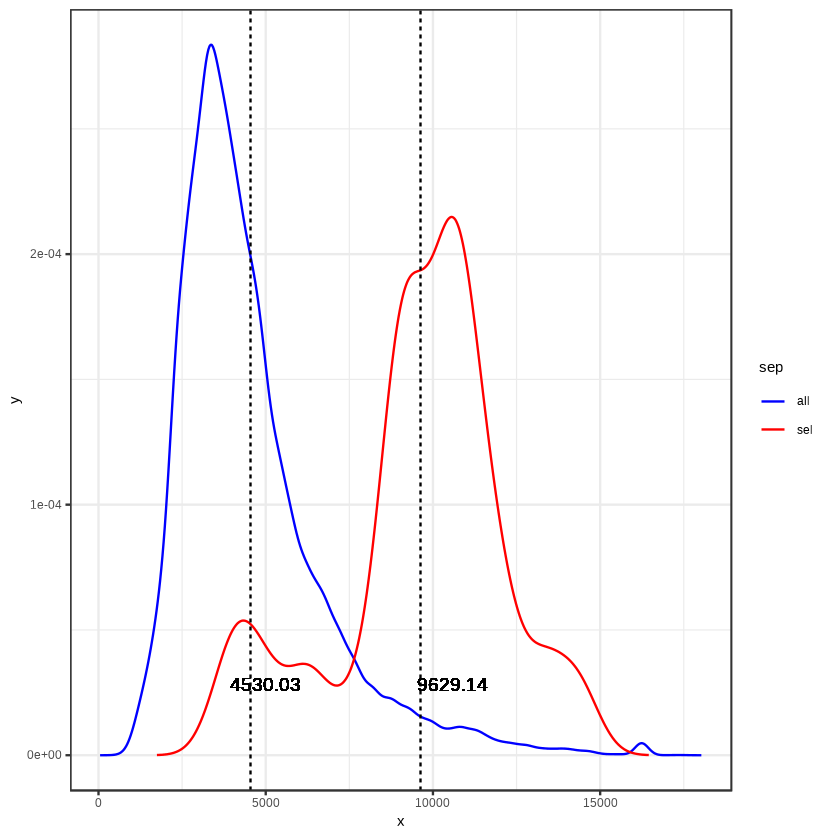

In [140]:
density_merge %>% ggplot(aes(x = x, y = y, colour = sep)) + geom_line() +
    scale_colour_manual(values = c("blue", "red")) + 
    geom_vline(xintercept = mean(all$py), lty = 2) + 
    geom_vline(xintercept = mean(sel$py), lty = 2) + 
    geom_text(aes(x = (mean(all$py) + mean(all$py) * 0.1), 
                  y = (max(y) * 0.1), 
                  label = round(mean(all$py), 2)),
                  color = "black", size = 5) +
    geom_text(aes(x = (mean(sel$py) + mean(sel$py) * 0.1), 
                  y = (max(y) * 0.1), 
                  label = round(mean(sel$py), 2)),
                  color = "black", size = 5) 

### 
### 회귀 분석

### ```floor_date( 날짜형, unit)``` : 단위에 맞게 날짜 올림
- ```unit``` : "month", "year", "week", "day"

In [ ]:
lubridate::floor_date()

In [142]:
library(lubridate)

In [217]:
all1 <- all %>% mutate(month = floor_date(ymd, "month")) %>%
    group_by(month) %>% summarise(all_py = mean(py))

In [218]:
sel1 <- sel %>% mutate(month = floor_date(ymd, "month")) %>%
    group_by(month) %>% summarise(sel_py = mean(py))

In [219]:
all1 %>% head(2)
sel1 %>% head(2)

month,all_py
<date>,<dbl>
2021-01-01,4401.306
2021-02-01,4330.190


month,sel_py
<date>,<dbl>
2021-01-01,9147.462
2021-02-01,9511.579


In [220]:
fit_all <- lm(all1$all_py ~ all1$month)
fit_sel <- lm(sel1$sel_py ~ sel1$month)

In [221]:
coef_all <- round(summary(fit_all)$coefficients[2], 1) * 365  # 전체(all) 회귀계수
coef_sel <- round(summary(fit_sel)$coefficients[2], 1) * 365  # 관심(sel) 회귀계수

### 회귀 그래프 작성
### ```grid::textGrob()``` : 회귀 계숫값을 텍스트로 만들어 저장
### ```grid::grobTree()```

In [222]:
library(grid)

In [223]:
grob_1 <- grobTree(textGrob(paste0("전체지역: ", coef_all, "만원(평당)"), x = 0.05, 
                            y = 0.88, hjust = 0, 
                            gp = gpar(col = "blue", fontsize = 13, fontface = "italic")))
grob_2 <- grobTree(textGrob(paste0("관심지역: ", coef_sel, "만원(평당)"), x = 0.05,  
                            y = 0.95, hjust = 0, 
                            gp = gpar(col = "red", fontsize = 16, fontface = "bold")))

In [224]:
library(ggpmisc)

In [225]:
gg <- ggplot(sel1, aes(x = month , y = sel_py)) + 
    geom_line() + xlab("월") + ylab("가격") + 
    stat_smooth(method = "lm", colour = "dark grey", linetype = "dashed")

`geom_smooth()` using formula = 'y ~ x'



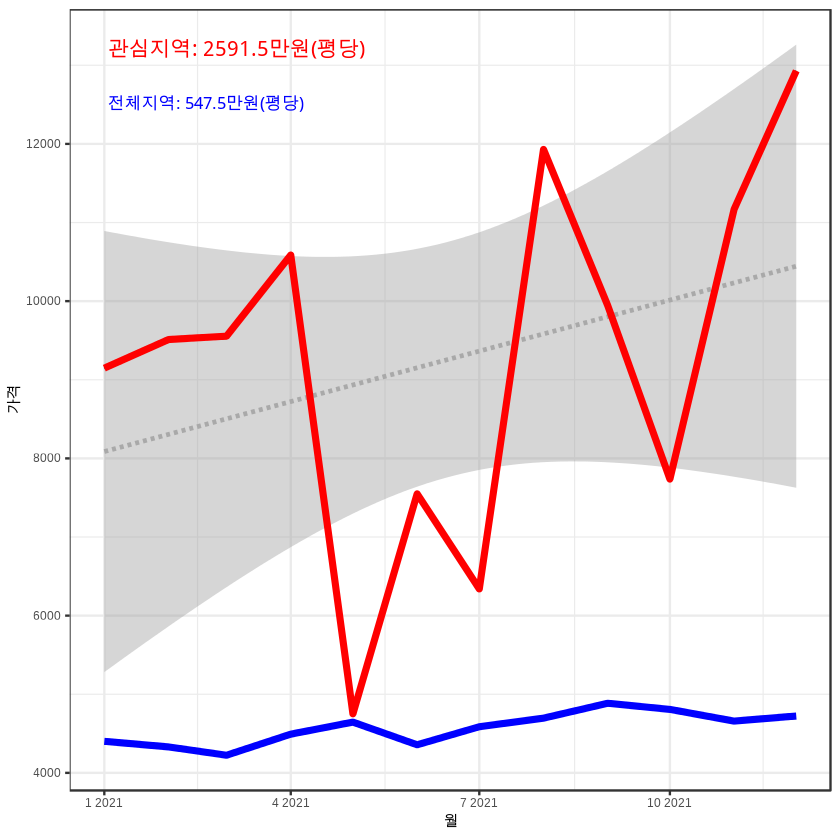

In [226]:
gg + geom_line(color = "red", size = 1.5) + 
    geom_line(data = all1, aes(x = month, y = all_py), color = "blue", size = 1.5) + 
    annotation_custom(grob_1) + annotation_custom(grob_2)

- 관심 지역 (빨강)은 1년에 평당 2591.5만원이 상승
- 서울시 전체 지역 (파랑)은 같은 기간동안 평당 547.5만원 상승

**=> 이는 한해동안 관심지역의 가격 상승률이 서울시 전체보다 평균 5배 이상 높다는 것을 의미**

### 
### 주성분 분석

In [228]:
pca_01 <- sel %>% group_by(apt_nm) %>% summarise(avg_con_yearㅠ = mean(con_year),
                                                 avg_floor = mean(floor),
                                                 avg_py = mean(py),
                                                 avg_area = mean(area))

In [236]:
colnames(pca_01) <- c("apt_nm", "신축", "층수", "가격", "면적")

In [238]:
m <- prcomp(~ 신축 + 층수 + 가격 + 면적, data = pca_01, scale = T)
summary(m)

Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.2870 1.0715 0.9377 0.56235
Proportion of Variance 0.4141 0.2870 0.2198 0.07906
Cumulative Proportion  0.4141 0.7011 0.9209 1.00000

#### 바이플롯 (biplot) : 주성분 분석 결과 가운데 가장 중요한 두 축을 기준으로 데이터를 시가화

In [239]:
library(ggfortify)

### ```loadings.label``` : 화살표와 텍스트 라벨 표시 유무
### ```loadings.label.size``` : 화살표의 텍스트 크기

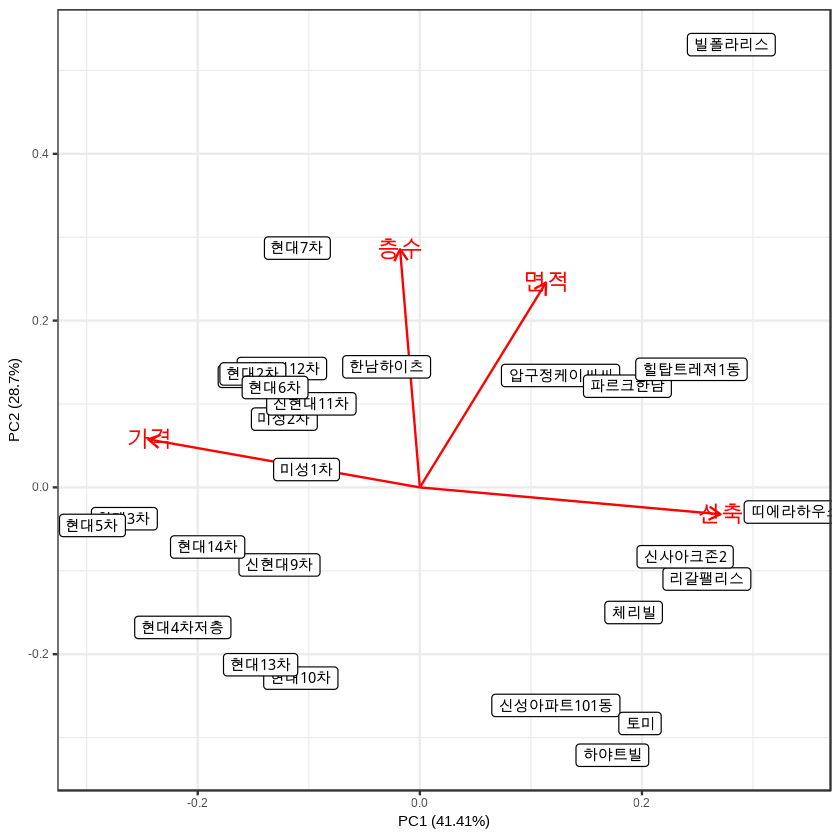

In [240]:
autoplot(m, loadings.label = T, loadings.label.size = 6) + 
    geom_label(aes(label = pca_01$apt_nm), size = 4)

- 현대 5차와 현대 3차는 평당 가격대가 높음
- 현대 7차는 층수가 높으며, 평당 가격대도 높음
- 빌폴라리스는 면적이 아주 넓으며, 신축 건물
- 띠에라하우스는 최신 아파트